In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

#all in all what batch normalization layer is doing is 
1. it has 4 parameters , bngain, bnbias, bnmean_running, bnstd_running
Calculate the mini-batch mean, denoted as μ:
μ = 1/m * Σ xᵢ (sum over the mini-batch)

Calculate the mini-batch variance, denoted as σ²:
σ² = 1/m * Σ (xᵢ - μ)² (sum over the mini-batch)

Normalize the feature maps using μ and σ²:
x̃ᵢ = (xᵢ - μ) / √(σ² + ε)
Here, ε is a small constant (e.g., 1e-5) added for numerical stability.

Scale and shift the normalized data:
yᵢ = γ * x̃ᵢ + β
Where γ and β are learnable parameters (scale and shift), initially set to 1 and 0.
bngain is initially set to 1 and bnbias to 0 and it changes in backprop , it basically allows the data to move , rather than keeping it strictly guassian all the time. initially the bnmeani is set to 0 and the standard deviation to 1 as we have initialized the weigths almost perfectly using he or some other weight initialization technique . which will have mean=0 and std=1 .

all of this is basically done to maintain the scale of the data so that they dont go to extreme and to stabalize.

In [9]:
# read in all the words
words = open('/Users/sairam/Downloads/makemore-master/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [10]:
len(words)

32033

In [11]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [12]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


the theory behind initialization is , when we initialize the weights , we want them to be more or less equal or closer to zero as possible , because if the random weights are initialized properly , we can converge to the global minima soon rather than wasting lot of epochs , but what happens when we use randn is that it initializes weights which are extreme leading to high initial loss , below we will be optimizing the weights and biases so that the initial weights are closer to zero , but in practical applications we would be using he initialization for relu etc , which work well as they adapt to the theory mentioned above

In [13]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) #* (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


as we know the problem with tanh activation function is vanishing gradient problem , to prove this when we plot h after flattening it using a hist plot we see that most of the numbers get closer to 1 or -1 and when we differentiate tanh (1-(t)**2) as you can see when we put t=1 or -1 the value it return is zero , so no matter how much we change the weights this will output zero leading to dead neuron , the main cause of this is W1 , b1 as when we initialize them they get assigned high value leading to extreme value being passed to tanh and they get assigned 1 or -1 when it passes through them. but as of today we can directly use the best initialization most he or some other and need not worry multiplying W1 by some number. 

# remember the ideal distribution of weights is 0 mean and 1 standard deviation 


Batch nomalization :- the above problem discussed wanted us to have roughly gaussian data before we pass the data onto some non linearity to avoid vanishing gradient problem . so following this , we apply normalization to the inputs before we pass that onto no linearity .

In [14]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation# always remeber when we use batch nor layer , the layer before that is wasteful containing bias so it is not useful to add bias
  
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias# this is the formulae for batch normalization
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.2394
  20000/ 200000: 2.3971
  30000/ 200000: 2.4796
  40000/ 200000: 1.9593
  50000/ 200000: 2.4193
  60000/ 200000: 2.4371
  70000/ 200000: 2.0502
  80000/ 200000: 2.3512
  90000/ 200000: 2.1712
 100000/ 200000: 1.9607
 110000/ 200000: 2.3153
 120000/ 200000: 2.0002
 130000/ 200000: 2.5127
 140000/ 200000: 2.3774
 150000/ 200000: 2.2193
 160000/ 200000: 1.9669
 170000/ 200000: 1.8630
 180000/ 200000: 2.1262
 190000/ 200000: 1.8570


 hpreact = bngain* (hpreact - bnmeani) / bnstdi +bnbias  

 bngain , we are initailly setting this to 1 as we want the batch which we pass to non linearity to be gaussian , but not during entire training because it would lead to backprop become less meaningfull .

 bnbias initially we set it to zero to be gaussian distribution but later it changes during backpropogation

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

we are doing the above because previously we coudnt input 1 input to the batch incase we deployed it somewhere as it required 32 examples for it to calculate mean and std and then work , writing the above we have calculated explicitly the mean and std so we can pass in 1 example to test and now since we are doing this explicitly outside the loop to avoid this we have included this in our main loop

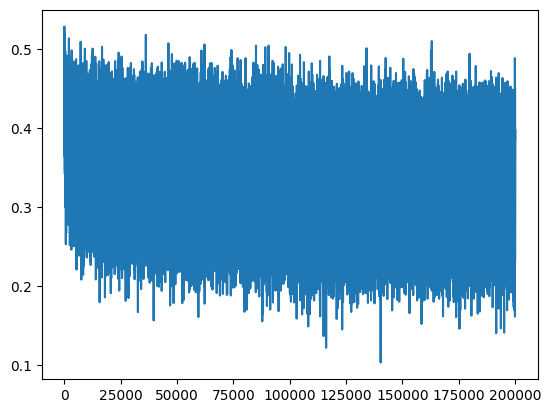

In [15]:
plt.plot(lossi)

In [16]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb=C[x]
  embcat=emb.view(emb.shape[0],-1)
  hpreact=torch.tanh(embcat @W1 +b1)
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain* (hpreact - bnmeani) / bnstdi +bnbias 
  h=torch.tanh(hpreact)
  logits=h@W2+b2
  loss=F.cross_entropy(logits,y)
  print(split,loss.item())

split_loss('train')
split_loss('val')

train 2.7672269344329834
val 2.8026177883148193


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h=torch.tanh(emb.view(1,-1) @W1 +b1)
      logits=h@W2 +b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

lringlyssellebrvgdhbhll.
rhlubrgengdugur.
denedge.
lillh.
lip.
likengdugwald.
gll.
lyllq.
lin.
shrberghhbreengd.
lillndikingth.
lik.
brgyven.
lyddne.
qhaylingrdennysh.
hll.
sammyroug.
zingly.
lill.
lil.
